In [95]:
import math
import glob
import random

import numpy as np
from scipy.ndimage.measurements import label

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2

from moviepy.editor import VideoFileClip
from IPython.display import HTML

from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib

%matplotlib inline

### Load and Display Cars and Not-Cars

In [96]:
def load_images(path):
    files = glob.glob(path, recursive=True)
    images = [mpimg.imread(img_path) for img_path in files]
    return images

def plot_images(imgs, cmap=None, titles=None, save=None):
    titles = titles or ['']*len(imgs)
    if len(titles) == 1:
        titles = titles*len(imgs)
    columns = min(len(imgs), 5)
    rows = math.ceil(len(imgs) / columns)
    fig = plt.figure(figsize=(16,8))
    for i, img in enumerate(imgs):
        plt.subplot(rows, columns, i+1)
        plt.imshow(img, cmap=cmap)
        plt.title(titles[i])
    plt.show()
    if save:
        fig.savefig(save)

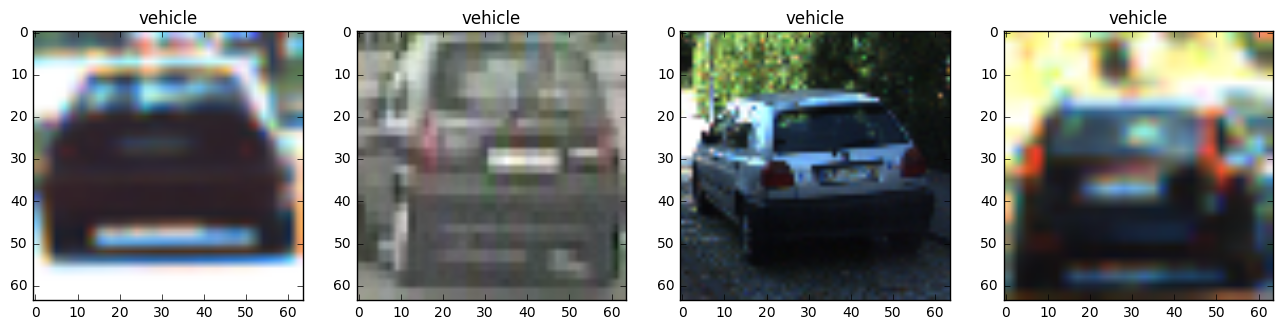

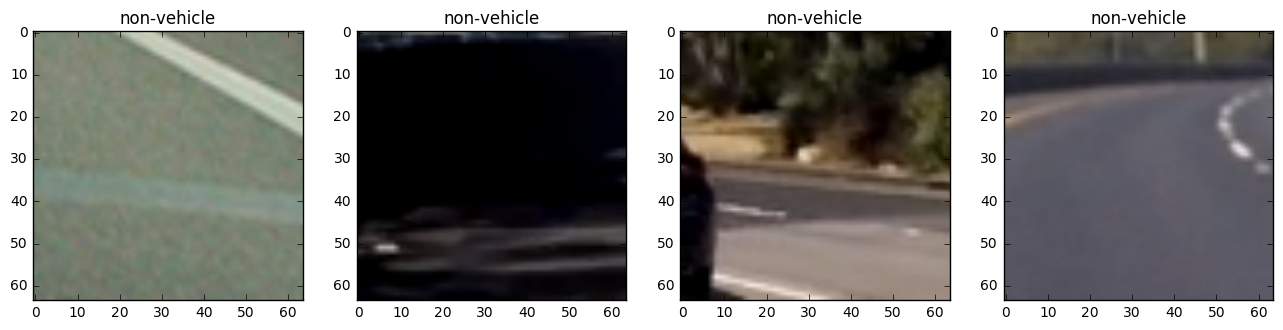

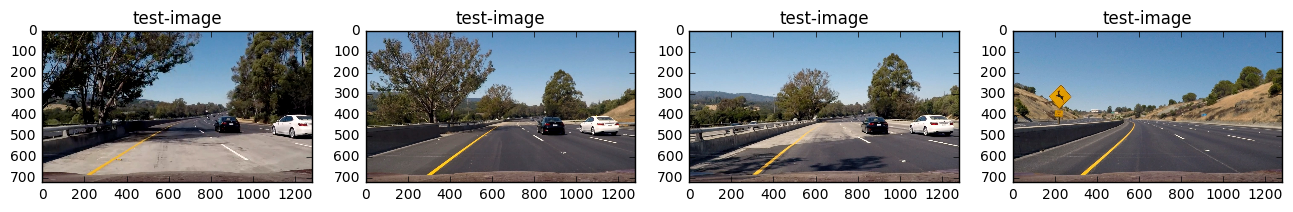

In [97]:
vehicles = load_images('/Users/kanna/Downloads/Vehicle-Detection/data/vehicles/*/*.png')
sample_vehicles = random.sample(vehicles, 4)
plot_images(sample_vehicles, titles=['vehicle'])

non_vehicles = load_images('/Users/kanna/Downloads/Vehicle-Detection/data/non-vehicles/*/*.png')
sample_non_vehicles = random.sample(non_vehicles, 4)
plot_images(sample_non_vehicles, titles=['non-vehicle'])

test_images = [mpimg.imread(img_path) for img_path in glob.glob('./test_images/*.jpg')]
sample_test_images = random.sample(test_images, 4)
plot_images(sample_test_images, titles=['test-image'])

In [98]:
print('train image shapes:', vehicles[0].shape, non_vehicles[0].shape)
print('test image shapes:', test_images[0].shape, test_images[1].shape)

train image shapes: (64, 64, 3) (64, 64, 3)
test image shapes: (720, 1280, 3) (720, 1280, 3)


### Extract HOG Features

In [114]:
def hog_features(img, pix_per_cell=12, cell_per_block=2, orient=9, vis=False):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=True) 
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=True)
        return features
    
def transform_image(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_red = img[:,:,0]
    img_green = img[:,:,1]
    img_blue = img[:,:,2]
    
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hsv_hue = hsv[:,:,0]
    hsv_saturation = hsv[:,:,1]
    hsv_value = hsv[:,:,2]
    hsv_gray = cv2.cvtColor(hsv, cv2.COLOR_RGB2GRAY)
    
    return [img_gray, img_red, img_green, img_blue, hsv_gray, hsv_hue, hsv_saturation, hsv_value]

def transform_image_YCrCb(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_red = img[:,:,0]
    img_green = img[:,:,1]
    img_blue = img[:,:,2]
    
    YCrCb_img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    YCrCb_img_luma = YCrCb_img[:,:,0]
    YCrCb_img_red = YCrCb_img[:,:,1]
    YCrCb_img_blue = YCrCb_img[:,:,2]
    YCrCb_img_gray = cv2.cvtColor(YCrCb_img, cv2.COLOR_RGB2GRAY)
    
    return [img_gray, img_red, img_green, img_blue, YCrCb_img_gray, YCrCb_img_luma, YCrCb_img_red, YCrCb_img_blue]

def transform_image_YUV(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_red = img[:,:,0]
    img_green = img[:,:,1]
    img_blue = img[:,:,2]
    
    YUV_img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    YUV_img_luma = YUV_img[:,:,0]
    YUV_img_red = YUV_img[:,:,1]
    YUV_img_blue = YUV_img[:,:,2]
    YUV_img_gray = cv2.cvtColor(YUV_img, cv2.COLOR_RGB2GRAY)
    
    return [img_gray, img_red, img_green, img_blue, YUV_img_gray, YUV_img_luma, YUV_img_red, YUV_img_blue]

def transform_image_HLS(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_red = img[:,:,0]
    img_green = img[:,:,1]
    img_blue = img[:,:,2]
    
    HLS_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    HLS_img_H = HLS_img[:,:,0]
    HLS_img_L = HLS_img[:,:,1]
    HLS_img_S = HLS_img[:,:,2]
    HLS_img_gray = cv2.cvtColor(HLS_img, cv2.COLOR_RGB2GRAY)
    
    return [img_gray, img_red, img_green, img_blue, HLS_img_gray, HLS_img_H, HLS_img_L, HLS_img_S]

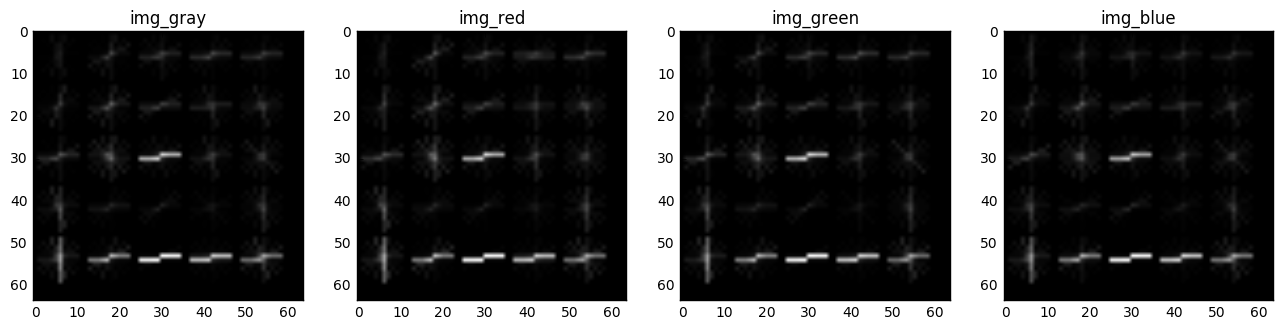

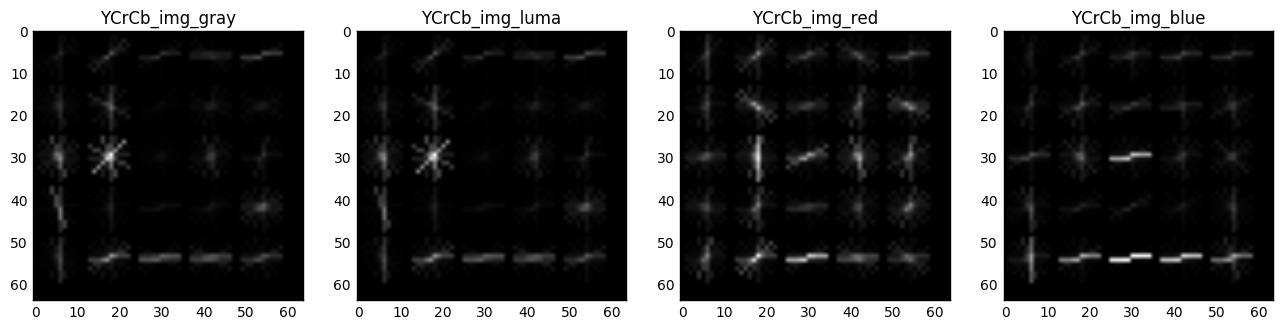

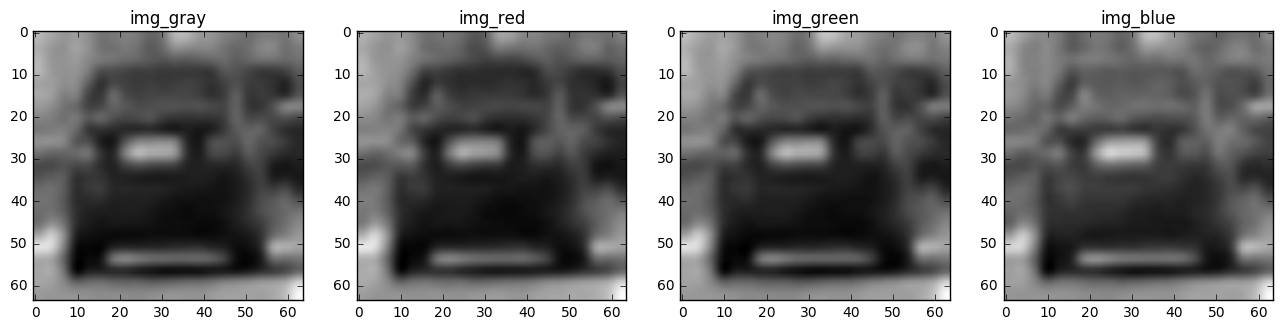

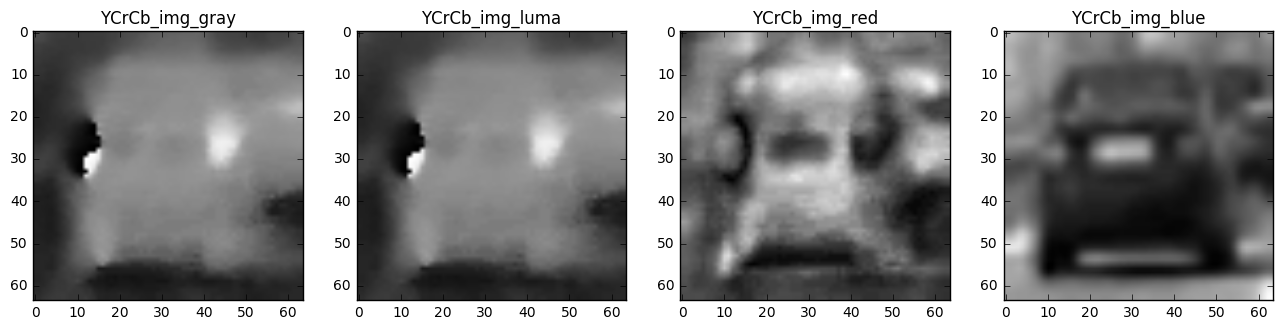

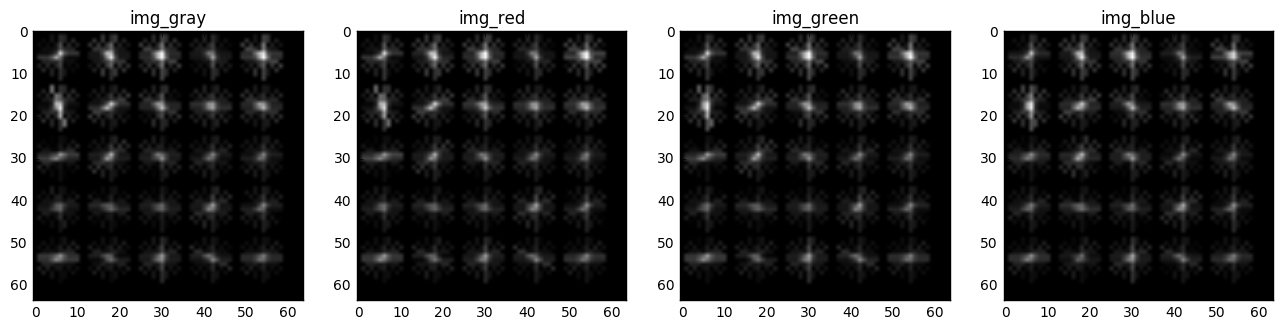

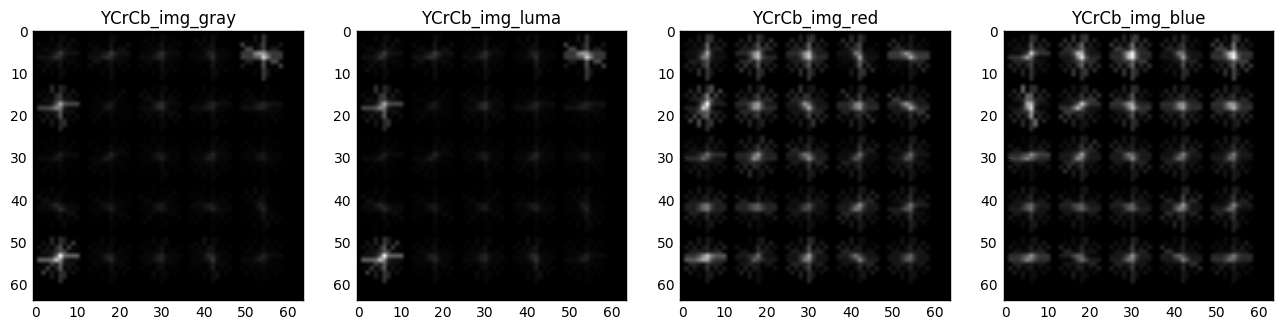

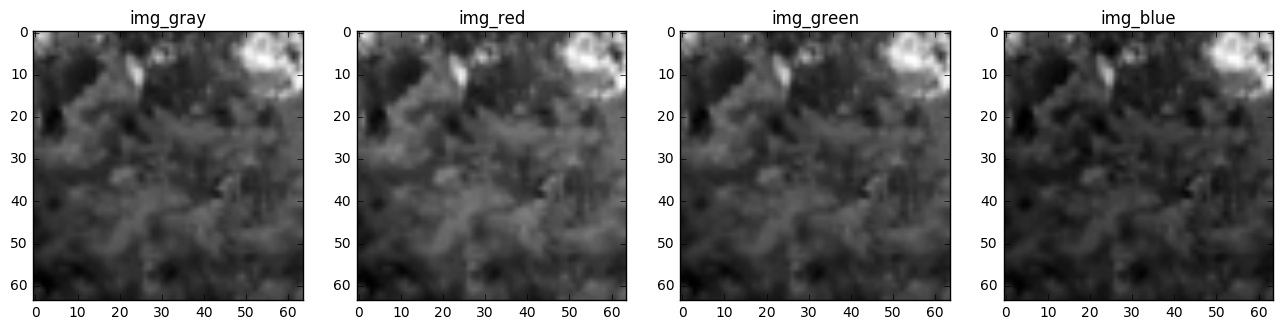

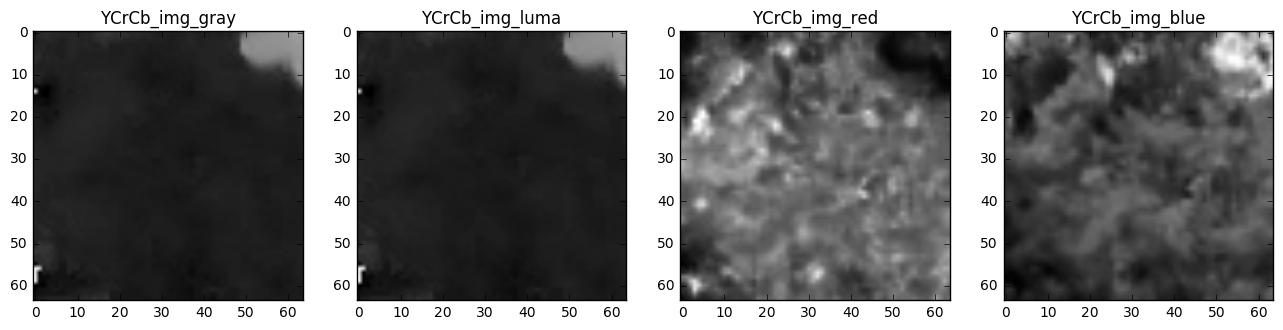

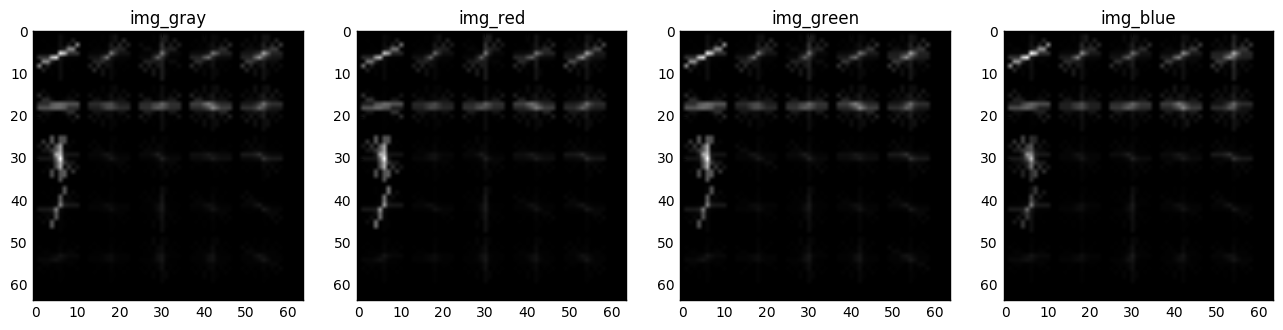

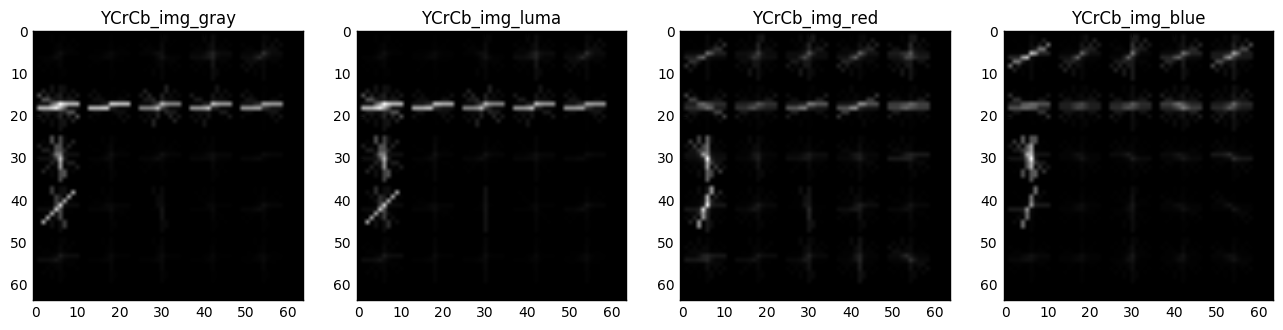

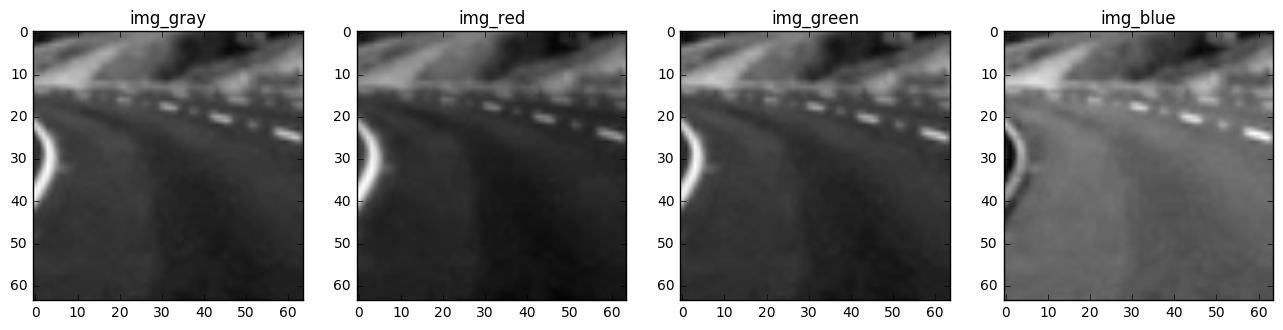

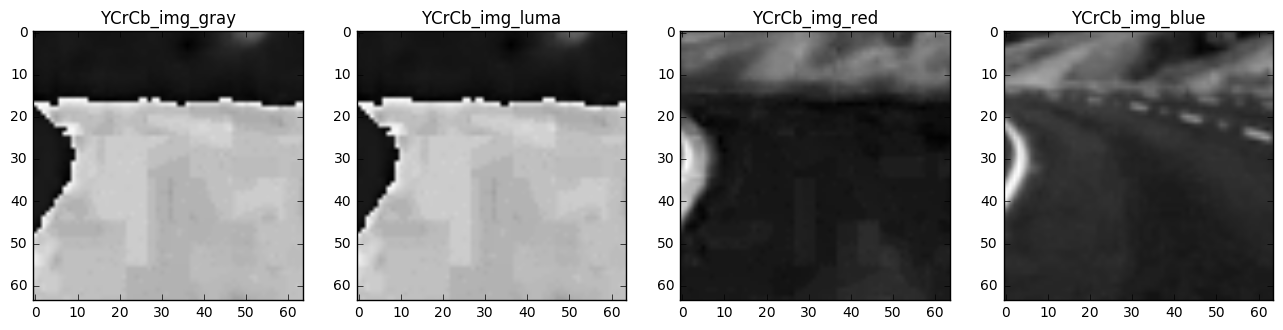

In [115]:
def test_img(img, name):
    img = np.copy(img)
    #images = transform_image(img)
    #images = transform_image_YCrCb(img)
    images = transform_image_HLS(img)
    #titles = ['img_gray', 'img_red', 'img_green', 'img_blue', 'hsv_gray', 'hsv_hue', 'hsv_saturation', 'hsv_value']    
    #titles = ['img_gray', 'img_red', 'img_green', 'img_blue', 'YCrCb_img_gray', 'YCrCb_img_luma', 'YCrCb_img_red', 'YCrCb_img_blue']    
    titles = ['img_gray', 'img_red', 'img_green', 'img_blue', 'HLS_img_gray', 'HLS_img_H', 'HLS_img_L', 'HLS_img_S']    
    features, results = zip(*[hog_features(i, vis=True) for i in images])
    plot_images(results[:4], cmap='gray', titles=titles[:4])
    plot_images(results[4:], cmap='gray', titles=titles[4:])

    plot_images(images[:4], cmap='gray', titles=titles[:4])
    plot_images(images[4:], cmap='gray', titles=titles[4:])

test_img(vehicles[2], '_vehicle')
test_img(non_vehicles[2], '_non_vehicle')
test_img(non_vehicles[4], '_non_vehicle_2')

In [116]:
def extract_hog_features(img):
    img = np.copy(img)
    #images = transform_image(img)
    #images = transform_image_YCrCb(img)
    #images = transform_image_YUV(img)
    images = transform_image_HLS(img)
    features = [hog_features(i) for i in images[5:8]]
    return np.concatenate(features)    

x_pre = vehicles + non_vehicles
y = np.array([1] * len(vehicles) + [0] * len(non_vehicles))
#print(np.copy(transform_image_YCrCb(x_pre[0])).shape)
#print(np.copy(transform_image_YCrCb(x_pre[0]))[5,0,0])
x = np.array([extract_hog_features(i) for i in x_pre])
#joblib.dump((x,y), 'x_and_y') # save x and y
#x, y = joblib.load('x_and_y') # restore x and y to save time

In [117]:
y = np.array([1] * len(vehicles) + [0] * len(non_vehicles))
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.10, random_state=42)
print('shapes:', X_train.shape, X_test.shape, y_train.shape, y_test.shape)

shapes: (15984, 1728) (1776, 1728) (15984,) (1776,)


### Pipeline

In [118]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

'''
clf = Pipeline([('feature_selection', SelectKBest(chi2, k=5000)),
                ('scaling', StandardScaler()),
                ('classification', LinearSVC(loss='hinge')),
               ])
'''
clf = Pipeline([('scaling', StandardScaler()),
                ('classification', LinearSVC(loss='hinge')),
               ])

clf.fit(X_train, y_train)

Pipeline(steps=[('scaling', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classification', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0))])

### Model Evaluation

In [119]:
clf.score(X_test, y_test)

0.97466216216216217

### Draw boxes around cars

In [120]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imgcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        cv2.rectangle(imgcopy, bbox[0], bbox[1], color, thick)
    return imgcopy

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],  
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # window limits
            startx = 0 if startx < 0 else startx
            endx = img.shape[1] if endx > img.shape[1] else endx
            starty = 0 if starty < 0 else starty
            endy = img.shape[0] if endy > img.shape[0] else endy
            # Append window position to list
            if (endx-startx == xy_window[0]) and (endy-starty == xy_window[1]):
                window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

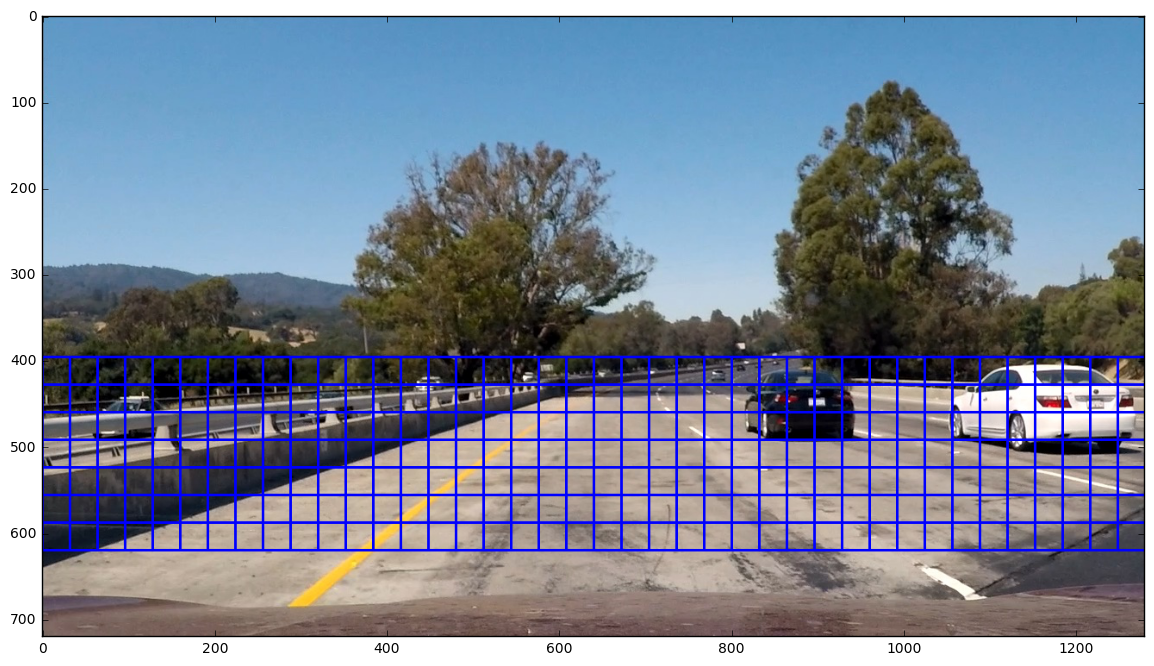

In [121]:
TEST_IMG = test_images[0]

WINDOW_SIZE = (128, 128) 
OVERLAP = (0.75, 0.75)


Y_START_STOP = [int(TEST_IMG.shape[0]*0.55), int(TEST_IMG.shape[0]*0.8)]
test_windows = slide_window(TEST_IMG, 
                            x_start_stop=[None, None], y_start_stop=Y_START_STOP, 
                            xy_window=WINDOW_SIZE, xy_overlap=OVERLAP)

imgwindows = draw_boxes(TEST_IMG, test_windows, color=(0, 0, 255), thick=2)
plot_images([imgwindows])

In [134]:
def find_cars(img, window_list, window_size, clf, train_height=64, train_width=64):
    imgwindow = np.zeros(window_size)
    window_listdetections = []
    # for each window...
    for bbox in window_list:
        # extract part of img
        top_L_x = bbox[0][0]
        top_L_y = bbox[0][1]
        bot_R_x = bbox[1][0]
        bot_R_y = bbox[1][1]
        imgwindow = img[top_L_y:bot_R_y,top_L_x:bot_R_x,:]
        imgresized = cv2.resize(imgwindow, (train_height, train_width))
        features = extract_hog_features(imgresized)
        #prediction = clf.predict(features)
        dec = clf.decision_function(features)
        dec_threshold = 0.99
        prediction = int(dec > dec_threshold)
        
        if prediction==1:
            window_listdetections.append(bbox)

    return window_listdetections

# find cars with different size windows
def find_cars_multiSize(img, clf, window_sizes=None, overlaps=None, startStops=None):
    window_sizes = window_sizes or [(64,64), (96, 96), (128,128), (192, 192), (256, 256)]
    overlaps = overlaps or [(0.8,0.8)]*len(window_sizes)
    startStops = startStops or [(int(TEST_IMG.shape[0]*0.55), int(TEST_IMG.shape[0]*0.8))]*len(window_sizes)

    detectionslist_total = []
    #for size in window_sizes:
    for size, overlap, start_stop in zip(window_sizes, overlaps, startStops):
        windows = slide_window(img, x_start_stop=[None, None], y_start_stop=start_stop, 
                               xy_window=size, xy_overlap=overlap)
        detectionslist = find_cars(img, windows, size, clf)
        detectionslist_total = detectionslist_total + detectionslist
    return detectionslist_total

# map the inputs to the function blocks
color_dict = {0: (255,   0,   0),  #red
              1: (  0, 255,   0),  #green
              2: (  0,   0, 255),  #blue
              3: (255, 255,   0),  #yellow
              4: (255,   0, 255),  #purple
              5: (255, 140,   0)   #orange
}

def draw_detections(img, detectionslist, draw_color=None):
    if draw_color is None:
        draw_color = color_dict[np.random.randint(0,5)]
    return draw_boxes(img, detectionslist, color=draw_color)

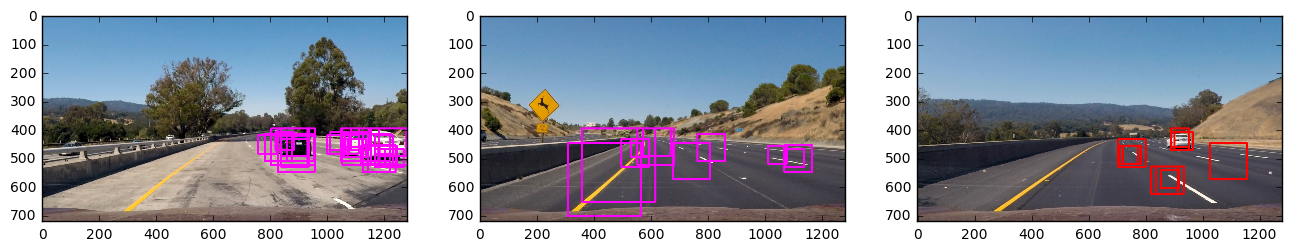

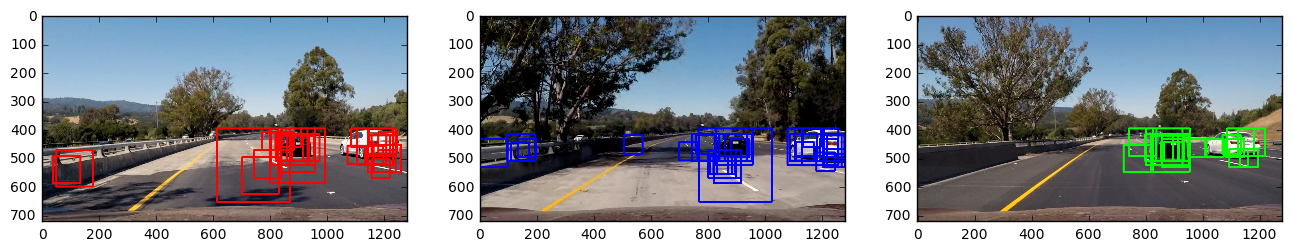

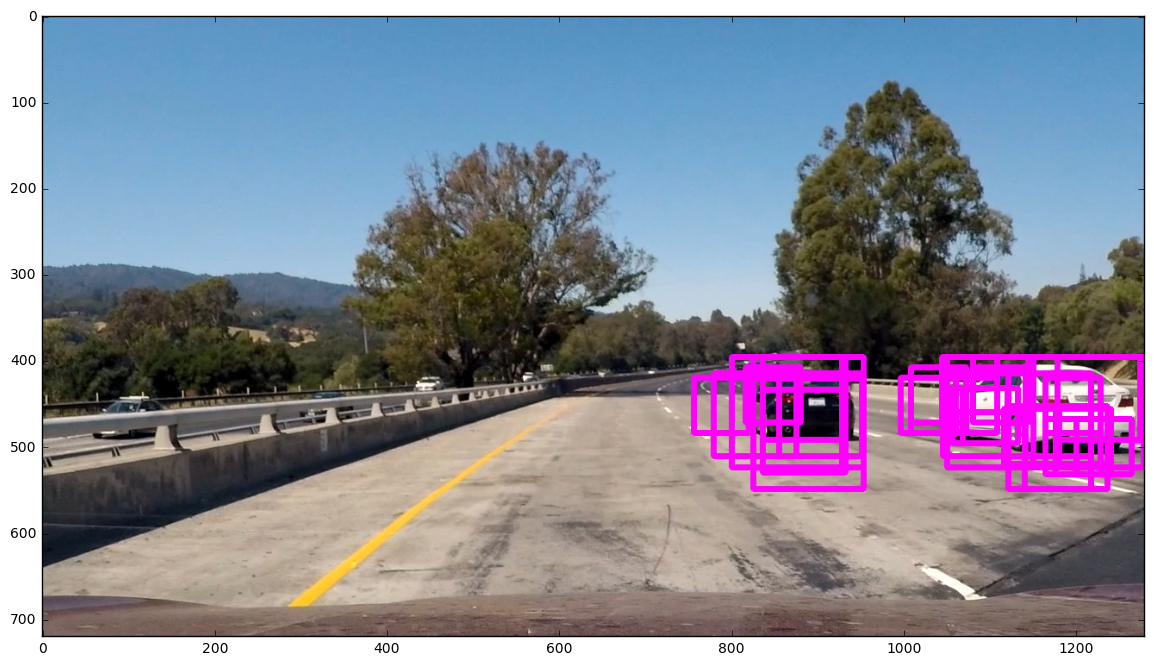

In [135]:
def find_and_mark(img, clf):
    detections = find_cars_multiSize(img, clf)
    imgboxed_cars = draw_detections(img, detections)
    return imgboxed_cars

imgs = [find_and_mark(i, clf) for i in test_images]
plot_images(imgs[:3])
plot_images(imgs[3:])

plot_images([imgs[0]])


In [136]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap < threshold] = 0
    heatmap[heatmap > 0] = 1
    return heatmap

def bbox_from_labels(labels):
    bbox_list = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bbox_list.append(bbox)        
    return bbox_list

heatmap_cont = None
def bboxes_from_detections(img, detections, threshold):
    global heatmap_cont
    heatmap = np.zeros((img.shape[0],img.shape[1]))
    heatmap = add_heat(heatmap, detections)
    
    heatmap_cont = heatmap_cont if not heatmap_cont is None else (heatmap*2)
    heatmap += heatmap_cont
    heatmap_cont = heatmap * 3/4

    heatmap = apply_threshold(heatmap, threshold)
    labels = label(heatmap)
    return bbox_from_labels(labels)

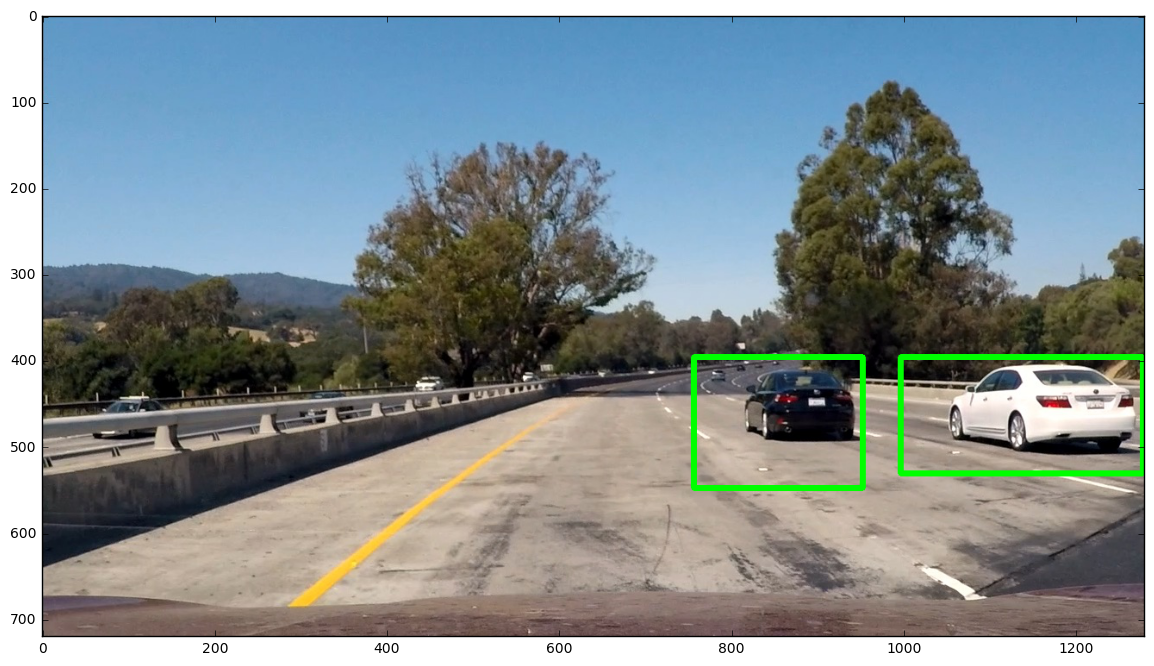

In [137]:
img = test_images[0]

#win_sizes = [(128,128), (192, 192)]
win_sizes = [(64,64), (128,128), (192, 192)]
# heatmap_cont = None

detectionsfor_heatmap = find_cars_multiSize(img, clf, window_sizes=win_sizes) 
combined_boxes = bboxes_from_detections(img, detectionsfor_heatmap, 3)
img = draw_detections(img, combined_boxes, draw_color=(0,255,0))

plot_images([img])

In [148]:
def combined_box(img, clf=clf):
    #win_sizes = [(128,128), (192, 192), (256, 256)]
    win_sizes = [(64, 64), (128,128)]
    detectionsfor_heatmap = find_cars_multiSize(img, clf, window_sizes=win_sizes) 
    combined_boxes = bboxes_from_detections(img, detectionsfor_heatmap, 3)
    imgcombined_box = draw_detections(img, combined_boxes, draw_color=(0,255,0))
    return imgcombined_box

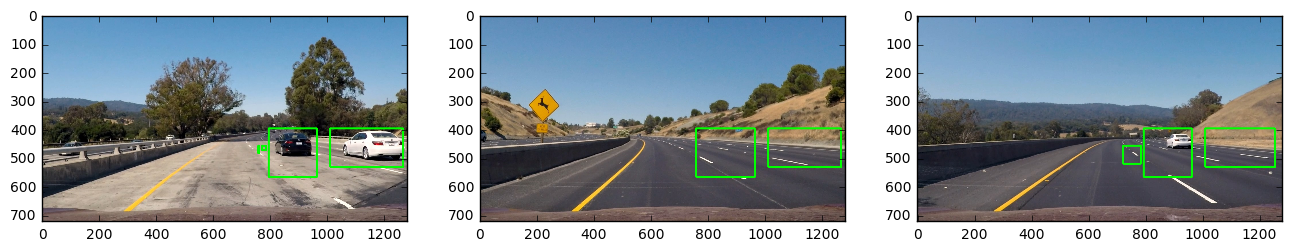

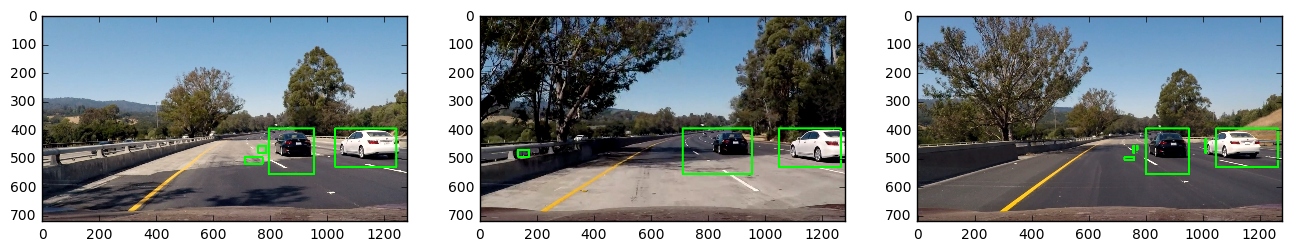

In [149]:
imgs = [combined_box(i, clf) for i in test_images]
plot_images(imgs[:3])
plot_images(imgs[3:])

#imgs = [combined_box(i, clf) for i in test_images]
#plot_images(imgs[:3])
#plot_images(imgs[3:])

### Video

In [150]:
heatmap_cont = None

vid_output = 'test_video_out.mp4'
clip = VideoFileClip('test_video.mp4', audio=False)

vid_clip = clip.fl_image(combined_box)
vid_clip.write_videofile(vid_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(vid_output))

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [02:01<00:02,  2.95s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 



In [151]:
heatmap_cont = None

vid_output = 'project_video_out.mp4'
clip = VideoFileClip('project_video.mp4', audio=False)

vid_clip = clip.fl_image(combined_box)
vid_clip.write_videofile(vid_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(vid_output))

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [59:17<00:02,  2.91s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

